In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from pcigale.sed import SED
from pcigale.sed import utils
from pcigale.sed_modules import get_module

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
plt.rcParams['figure.figsize'] = [20 , 10]

## Build the CIGALE model

In [2]:
def generate_model(AGE, EBmV, TAU=1e-10):
    
    # Initialisation of a new galaxy / SED
    galaxy = SED()
    
    # Get the CIGALE SED generation module, i.e. SFH module, SPS module and DUST module
    sfh_module = get_module(
        'sfh2exp',
        tau_main = TAU,
        tau_burst = 1,
        burst_age = 1,
        age = AGE,
        f_burst = 0,
        normalise = True) # Normalise the SFH to produce one solar mass
    
    sps_module = get_module('bc03', imf = 1, metallicity = 0.02)

    dust_module = get_module('dustatt_calzleit', E_BVs_young = EBmV/0.44, E_BVs_old_factor = 0.44)

    # We process the SED object with all the modules in the right order
    sfh_module.process(galaxy)
    sps_module.process(galaxy)
    dust_module.process(galaxy)
    modwave = galaxy.wavelength_grid*10 # Convert nm to A
    
    # This is the LUMINOSITY density from the stellar components in W/nm
    stellar_lum = galaxy.luminosities['stellar.young']+galaxy.luminosities['stellar.old']
    
    # This is the FLUX density from the stellar components in W/(m2*nm) at 10 parsec, here needs distance in m as per CIGALE's default units
    # Convert  in to cgs units erg(cm2*s*A). x1000 W/m2 to erg/(cm2*s) and x0.1 for nm to A = factor of x100 to be applied
    stellar_flux = utils.luminosity_to_flux(stellar_lum, 10. * 3.0865E16)*100
    
    # Repeat for the attenuated SED
    stellar_lum_att = np.copy(stellar_lum)
    stellar_lum_att += galaxy.luminosities['attenuation.stellar.young']+galaxy.luminosities['attenuation.stellar.old']
    stellar_flux_att = utils.luminosity_to_flux(stellar_lum_att, 10. * 3.0865E16)*100
    
    return modwave, stellar_flux, stellar_flux_att

## Import Data

In [3]:
# Now read one of the SDSS spectra
hdu = fits.open('Spectra\SDSS_spec_G1.fits')
spflux = hdu[0].data*1e-17 
spwave = hdu[0].header['CRVAL1']+np.arange(hdu[0].header['NAXIS1'])*hdu[0].header['CDELT1'] 
redshift = hdu[0].header['REDSHIFT']

## Renormalize CIGALE units to Data units

### 1) Distance renormalization: from $10pc$ to the actual distance of the source in $Mpc$

At first order, a galaxy with redshift $z$ is situated at a distance:

$d = \dfrac{z \times c}{H_o}$

In [4]:
print(f'G1 is at a distance of roughly {redshift*3e10/70e5} Mpc')

G1 is at a distance of roughly 84.0 Mpc


Compute a conversion factor that will be used to transform fluxes from $10pc$ to $Mpc$

$
L = 4\pi d^2 \times \textrm{flux} = \textrm{const}
\:\: \Longrightarrow \:\:
\begin{cases}
    L = 4\pi (d_{\textrm{cigale}})^2 \times f_{\textrm{cigale}} \\
    L = 4\pi (d_{\textrm{galaxy}})^2 \times f_{\textrm{galaxy}}
\end{cases}
\:\: \Longrightarrow \:\:
f_{\textrm{galaxy}} = \left(\dfrac{d_{\textrm{cigale}}}{d_{\textrm{galaxy}}}\right)^2 \times f_{\textrm{cigale}} = \left(\dfrac{10\;\textrm{pc}}{84\;\textrm{Mpc}}\right)^2 \times f_{\textrm{cigale}}
$

In [5]:
conversion_factor = (1e-5 / (redshift*3e10/70e5))**2
print(f'flux_galaxy / flux_cigale = {conversion_factor}')

flux_galaxy / flux_cigale = 1.4172335600907031e-14


### 2) Mass renormalization: from solar mass to the actual source mass

just multiply the CIGALE flux for the number of solar masses of the source.

### 3) Shifting the data wavelengths

We should also shift the data wavelengths, in order to remove the redshift effect and be able to analyze the correct spectral lines.

$\lambda_{\textrm{fixed}} = \dfrac{\lambda_{\textrm{data}}}{1 + z}$

## Plot the spectra

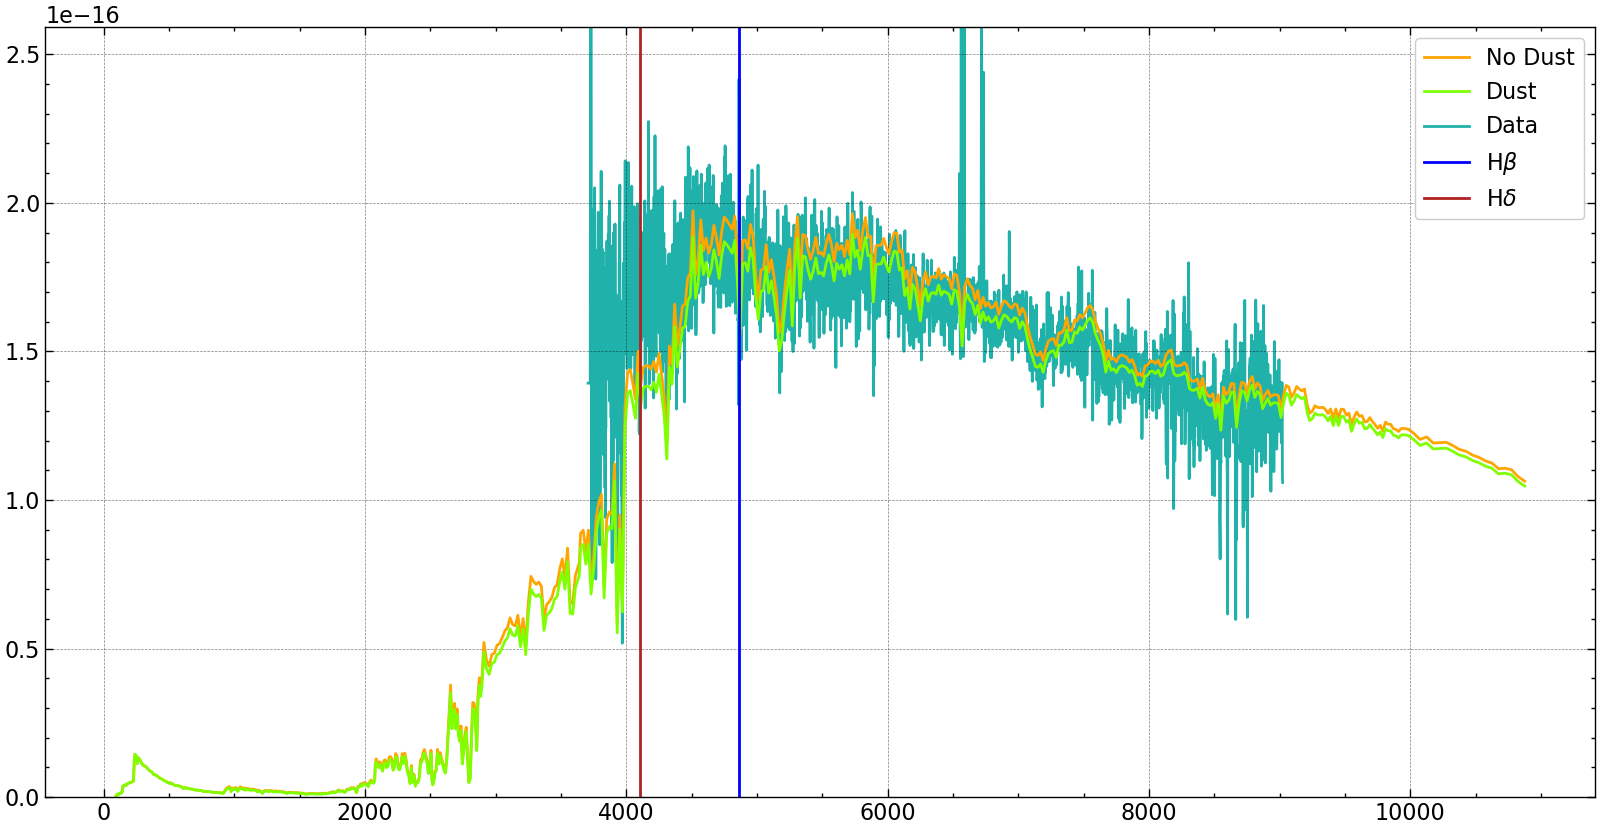

In [6]:
# Now read one of the SDSS spectra
hdu = fits.open('Spectra\SDSS_spec_G1.fits')
spflux = hdu[0].data*1e-17 
spwave = hdu[0].header['CRVAL1']+np.arange(hdu[0].header['NAXIS1'])*hdu[0].header['CDELT1'] 
redshift = hdu[0].header['REDSHIFT']
spwave = spwave/(1+redshift)

x_G1, y_G1, y_att_G1 = np.array(generate_model(AGE=int(2e3), EBmV=0.01))[:,:700]

mass = 4.5e8
y_G1 = y_G1 * conversion_factor * mass
y_att_G1 = y_att_G1 * conversion_factor * mass

plt.plot(x_G1, y_G1, color='orange', label='No Dust')
plt.plot(x_G1, y_att_G1, color='chartreuse', label='Dust')
plt.plot(spwave, spflux, color='lightseagreen', label='Data', zorder=0)
plt.ylim(0, np.max(spflux)/2)
plt.axvline(4861, label='H$\\beta$', color='blue')
plt.axvline(4102, label='H$\\delta$', color='firebrick')
plt.legend()

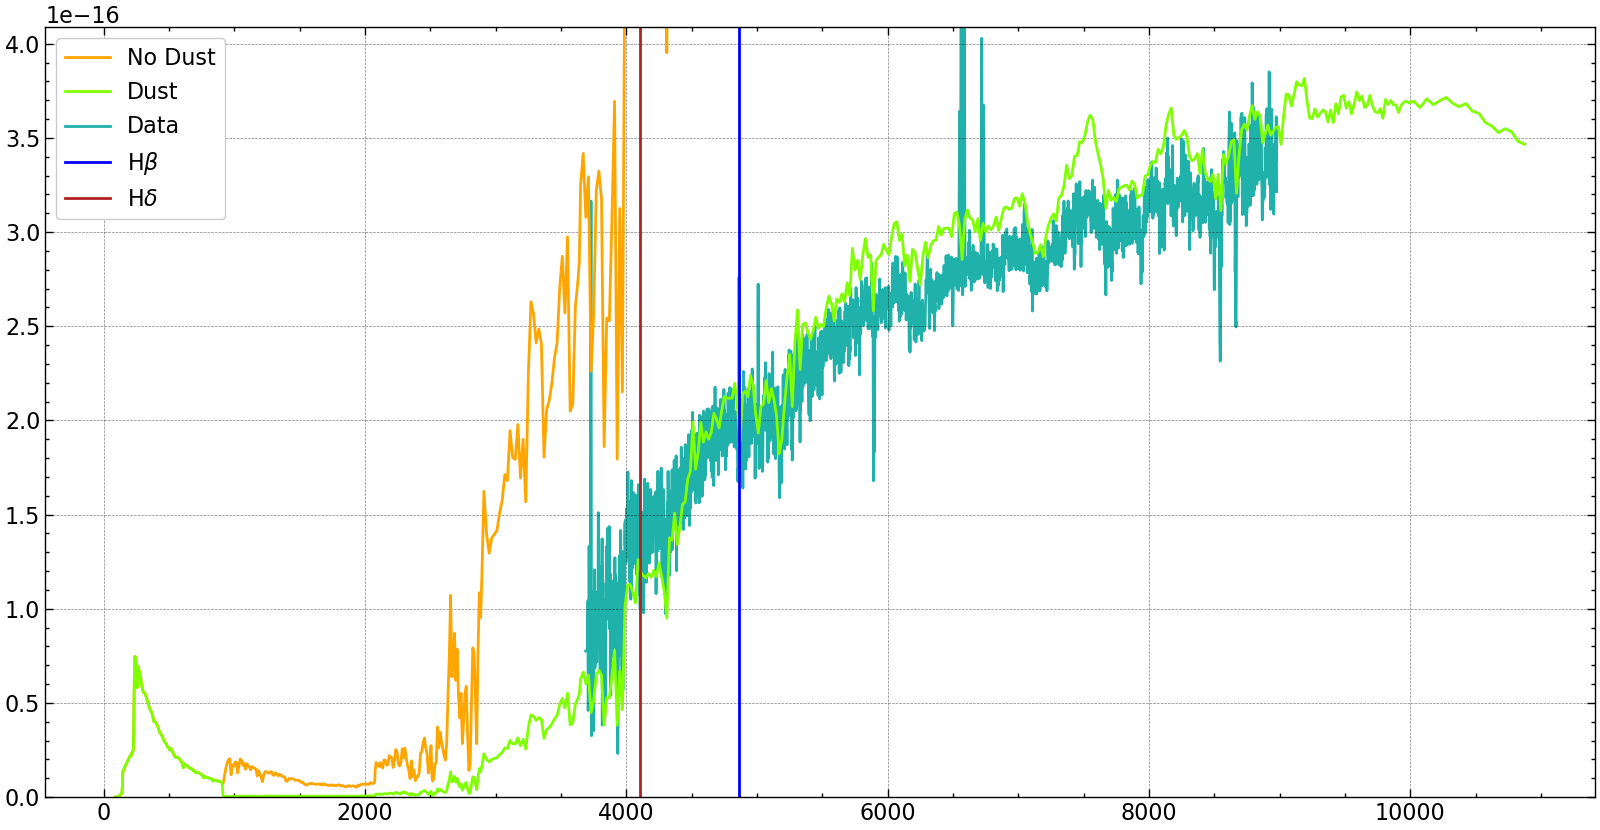

In [7]:
# Now read one of the SDSS spectra
hdu = fits.open('Spectra\SDSS_spec_G2.fits')
spflux = hdu[0].data*1e-17
spwave = hdu[0].header['CRVAL1']+np.arange(hdu[0].header['NAXIS1'])*hdu[0].header['CDELT1'] 
redshift = hdu[0].header['REDSHIFT']
spwave = spwave/(1+redshift)

x_G2, y_G2, y_att_G2 = np.array(generate_model(AGE=int(5e3), EBmV=0.3))[:,:700]

mass = 4.5e9
y_G2 = y_G2 * conversion_factor * mass
y_att_G2 = y_att_G2 * conversion_factor * mass

plt.plot(x_G2, y_G2, color='orange', label='No Dust')
plt.plot(x_G2, y_att_G2, color='chartreuse', label='Dust')
plt.plot(spwave, spflux, color='lightseagreen', label='Data', zorder=0)
plt.ylim(0, np.max(spflux)/2)
plt.axvline(4861, label='H$\\beta$', color='blue')
plt.axvline(4102, label='H$\\delta$', color='firebrick')
plt.legend()

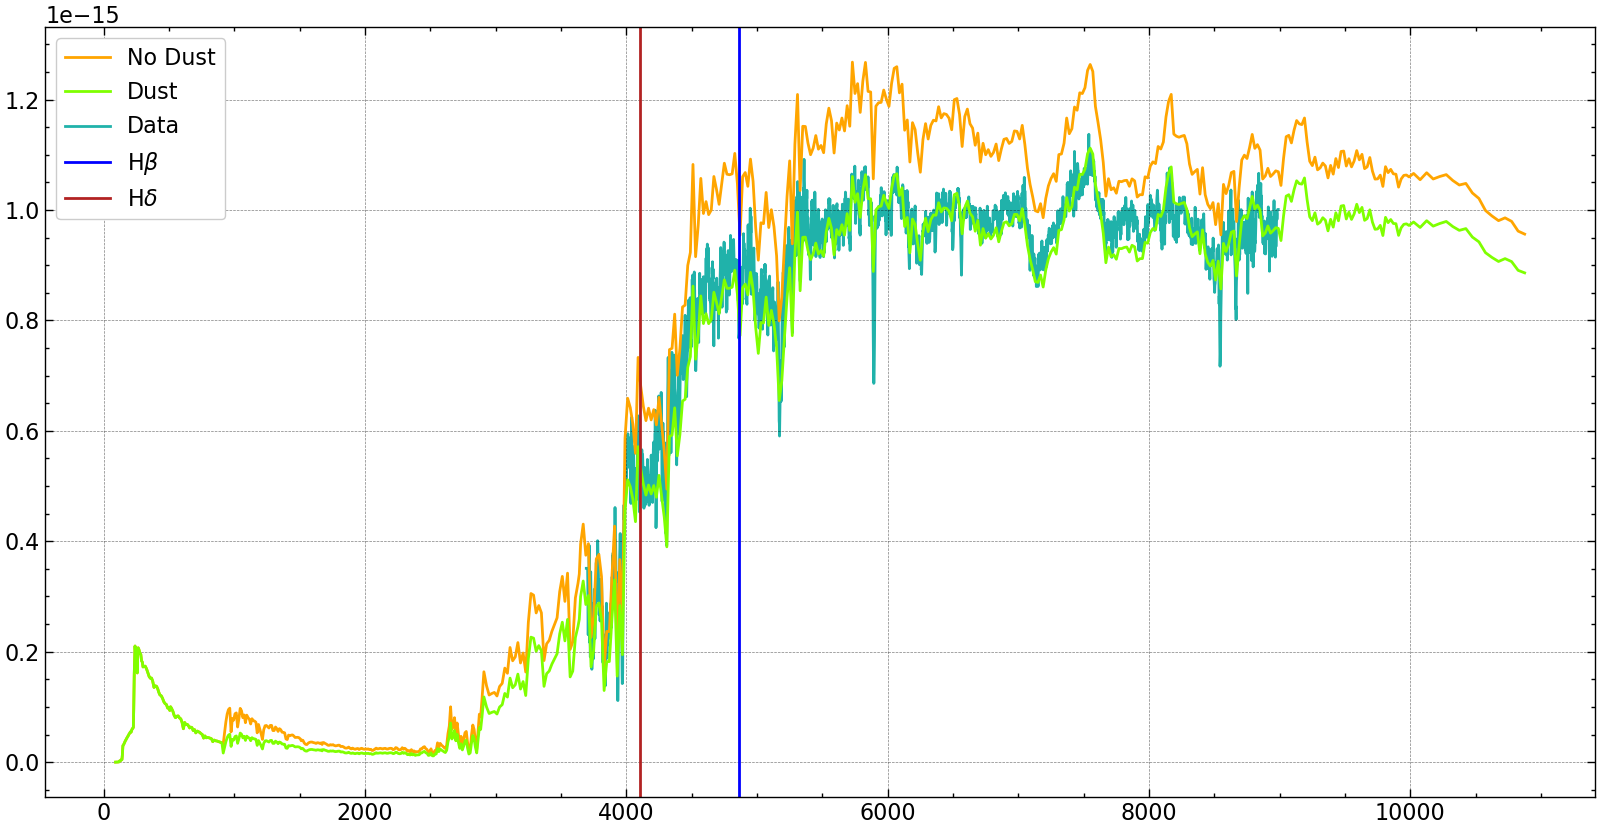

In [8]:
# Now read one of the SDSS spectra
hdu = fits.open('Spectra\SDSS_spec_G3.fits')
spflux = hdu[0].data*1e-17
spwave = hdu[0].header['CRVAL1']+np.arange(hdu[0].header['NAXIS1'])*hdu[0].header['CDELT1'] 
redshift = hdu[0].header['REDSHIFT']
spwave = spwave/(1+redshift)

x_G3, y_G3, y_att_G3 = np.array(generate_model(AGE=int(13e3), EBmV=0.05))[:,:700]

mass = 1.5e10
y_G3 = y_G3 * conversion_factor * mass
y_att_G3 = y_att_G3 * conversion_factor * mass

plt.plot(x_G3, y_G3, color='orange', label='No Dust')
plt.plot(x_G3, y_att_G3, color='chartreuse', label='Dust')
plt.plot(spwave, spflux, color='lightseagreen', label='Data', zorder=0)
plt.axvline(4861, label='H$\\beta$', color='blue')
plt.axvline(4102, label='H$\\delta$', color='firebrick')
plt.legend()